In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(ggpubr)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(factoextra)
library(ggrepel)
library(dplyr)
library(plyr)
library(cowplot)
library(lme4)
library(mice)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘ggpubr’

The following object is masked from ‘package:VennDiagram’:

    rotate

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to den

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC <- "#FFCC00"

In [3]:
title_size <- 10

In [4]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    #print(sort(unique(braak)))
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}

get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

In [34]:
setwd("~/ownCloud/Meng/")

In [44]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")

metadata <- metadata_clean
colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [45]:
metadata_clean

,nbb,autopsy,sampleprepRandomization (4 batches),zmRandomization (10 batches),Autopsy_nr,GROUP,Mass-Spec filenames (1),Mass-Spec filenames (2),Diagnosis,sex,⋯,braak,amyloid,pmd,ph,weight,csf,apoe,barcode,Abeta,APOE
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,2004-038,S04/120,91,175,S04/120,AD,20190424_1_S04_120_AD_175,NA,AD -,f,⋯,5,C,05:55,6.7,827,25,33,2004031398,3,33
2,2005-071,S05/265,83,194,S05/265,AD,20190502_2_S05_265_AD_194,20190606_2_S05_265_AD_RERUN,AD -,m,⋯,6,C,07:30,6.44,1021,45,33,2005060610,3,33
3,2000-052,S00/107,119,88,S00/107,AD,20190412_3_S00_107_AD_88,NA,AD -,f,⋯,6,C,06:20,6.49,874,80,33,2000033273,3,33
4,2005-029,S05/106,47,15,S05/106,AD,20190326_4_S05_106_AD_015,NA,AD -,m,⋯,5,C,04:10,6.4,1252,135,33,2005023738,3,33
5,2005-043,05/154,35,121,05/154,AD,20190418_5_05_154_AD_121,NA,AD -,f,⋯,6,C,06:05,6.39,1123,140,32,Alzheimer's disease,3,32
6,2004-023,04/062,118,111,04/062,AD,20190416_6_04_062_AD_111,NA,AD -,f,⋯,6,C,05:50,6.75,845,100,33,Alzheimer's disease,3,33
7,2003-057,S03/150,180,79,S03/150,AD,20190412_7_S03_150_AD_079,NA,AD -,f,⋯,6,C,03:50,6.5,985,110,32,2003042748,3,32
8,2002-099,S02/307,155,86,S02/307,AD,20190412_8_S02_307_AD_86,NA,AD -,m,⋯,6,C,05:30,6.18,1086,155,33,2002075077,3,33
9,1993-014,S93/025,149,57,S93/025,AD,20190401_9_S93_025_AD_057,20190606_9_S93_025_AD_RERUN,AD -,f,⋯,5,NA,02:25,6.5,861,20,33,1993012203,NA,33


In [7]:
#metadata_numeric <- apply(metadata[c("age", "braak", "Abeta", "weight", "APOE")], 
#                          2, as.numeric) %>% as.data.frame()
#metadata_numeric
#metadata_numeric$sex <- as.numeric(factor(metadata$sex, levels = c("f", "m")))
#summary(metadata_numeric)
#metadata_MICE <- mice(metadata_numeric, m=10, #predictorMatrix = pm, 
#                                                  method="pmm", seed=1234, print=FALSE)
#metadata_MICE_complete <- complete(metadata_MICE, 1) #+ 
#                                                  #complete(metadata_MICE, 2) +
#                                                  #complete(metadata_MICE, 3) + 
#                                                  #complete(metadata_MICE, 4) +
#                                                  #complete(metadata_MICE, 5) + 
#                                                  #complete(metadata_MICE, 6) +
#                                                  #complete(metadata_MICE, 7) + 
#                                                  #complete(metadata_MICE, 8) +
#                                                  #complete(metadata_MICE, 9) + 
#                                                  #complete(metadata_MICE, 10)) / 10
#
#summary(metadata_MICE_complete)
#metadata_MICE_complete[which(is.na(metadata_numeric$braak)), ]

In [8]:
colSums(is.na(metadata))

nbb                             autopsy 
                                  0                                   0 
sampleprepRandomization (4 batches)        zmRandomization (10 batches) 
                                  0                                   0 
                         Autopsy_nr                               GROUP 
                                  0                                   0 
            Mass-Spec filenames (1)             Mass-Spec filenames (2) 
                                  0                                 208 
                          Diagnosis                                 sex 
                                  0                                   0 
                                age                               braak 
                                  0                                   2 
                            amyloid                                 pmd 
                                 28                                   2 
                                 ph                              weight 
                                 13                                   2 
                                csf                                apoe 
                                  8                                  18 
                            barcode                               Abeta 
                                 66                                  19 
                               APOE 
                                 16

In [9]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)


names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

colSums(is.na(metadata))

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="AD") & (!is.na(metadata$amyloid))),]$amyloid)
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="ND") & (!is.na(metadata$amyloid))),]$amyloid)

metadata$O_amyloid <- sapply(metadata$amyloid, function(x){
    if(is.na(x)){
        return(NA)
    }
    if(round(x) == 0){
        return("O")
    }
    if(round(x) == 1){
        return("A")
    }
    if(round(x) == 2){
        return("B")
    }
    if(round(x) == 3){
        return("C")
    }
    
})

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


[1] 3448  191

nbb   autopsy       sex       age    weight     GROUP       pmd     braak 
        0         0         0         0         2         0         2         2 
  amyloid      apoe filenames 
       17        16         0

In [10]:
summary(metadata)

     nbb              autopsy              sex                 age       
 Length:190         Length:190         Length:190         Min.   : 50.0  
 Class :character   Class :character   Class :character   1st Qu.: 78.0  
 Mode  :character   Mode  :character   Mode  :character   Median : 89.0  
                                                          Mean   : 86.8  
                                                          3rd Qu.:100.0  
                                                          Max.   :111.0  
    weight             GROUP               pmd                braak      
 Length:190         Length:190         Length:190         Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :4.000  
                                                          Mean   :3.611  
                                                          3rd Qu.:5.000  
                                      

In [11]:
metadata_imp <- metadata

In [12]:
save(metadata_imp, file = "100_plus_project/Metadata/metadata_imp_20230223.Rdata")

In [59]:
table(metadata$apoe, metadata$GROUP)

    
     AD CHC ND
  22  0   1  2
  23  0  11  0
  24  0   2  0
  32  8   0  4
  33 33  31 37
  34  0   4  0
  42  2   0  1
  43 45   0  8
  44  0   0  1

In [60]:
metadata$apoe_has4 <- NA

metadata[which(metadata$apoe %in% c("24", "34", "42", "43", "44")), ]$apoe_has4 <- 1
metadata[which(metadata$apoe %in% c("22", "23", "32", "33")), ]$apoe_has4 <- 0

In [62]:
table(metadata$apoe_has4)


  0   1 
127  63 

In [12]:
metadata$famyloid <- metadata$amyloid

In [13]:
metadata[which((metadata$amyloid == 3) & (metadata$GROUP == "ND")), ]$famyloid <- 2

In [14]:
table(metadata$famyloid, metadata$GROUP)

   
    AD CHC ND
  0  0   3 13
  1  0  18 23
  2  7  14 17
  3 81  14  0

In [15]:
table(metadata$braak, metadata$GROUP)

   
    AD CHC ND
  0  0   0  6
  1  0   1 22
  2  0   6 17
  3  0  24  8
  4 20  14  0
  5 43   4  0
  6 25   0  0

In [21]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [16]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,A,0.6,6.166667
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,C,1.0,5.283333
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,A,1.0,7.916667
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,C,1.0,5.916667
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,C,0.6,4.583333
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,C,2.6,5.500000
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,C,1.0,5.083333
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,C,3.2,2.000000
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,O,1.0,7.250000


In [17]:
corr_test <- function(x, y, method){
    res <- cor.test(x, y, method = method, exact = FALSE)
    #print(res)
    return(c(res$estimate, res$p.value))
}

In [28]:
Abeta_intens_corr <- as.data.frame(t(apply(protein_intensity_combat, 1, 
                         corr_test, metadata$amyloid, method = "pearson")))
colnames(Abeta_intens_corr) <- c("amyloid_rho", "amyloid_p")

In [29]:
Braak_intens_corr <- as.data.frame(t(apply(protein_intensity_combat, 1, 
                         corr_test, metadata$fBraak, method = "pearson")))
colnames(Braak_intens_corr) <- c("braak_rho", "braak_p")

In [32]:
age_intens_corr <- as.data.frame(t(apply(protein_intensity_combat, 1, 
                         corr_test, metadata$age, method = "pearson")))
colnames(age_intens_corr) <- c("age_rho", "age_p")

In [53]:
corr_res <- cbind(Braak_intens_corr, Abeta_intens_corr, age_intens_corr)

In [54]:
corr_res

,braak_rho,braak_p,amyloid_rho,amyloid_p,age_rho,age_p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC12A2,-0.15456697,3.322842e-02,-0.106274443,1.444657e-01,-0.302289727,2.246422e-05
CASKIN1,-0.63711044,4.999366e-23,-0.498893591,2.374111e-13,0.311868646,1.185761e-05
GNG2,-0.10408200,1.529788e-01,-0.197188255,6.392404e-03,0.177283118,1.440637e-02
CARNS1,0.14464028,4.647487e-02,0.139555077,5.481398e-02,-0.249196369,5.260532e-04
FH,0.32125351,6.203651e-06,0.247685836,5.701547e-04,0.045563999,5.324725e-01
EFHD2,0.34850224,8.331859e-07,0.240218018,8.427922e-04,-0.063440097,3.845370e-01
PCLO,-0.19970409,5.736965e-03,-0.157372747,3.012452e-02,0.078425271,2.821323e-01
HSPA1A;HSPA1B,0.52509125,7.402881e-15,0.392175984,2.194764e-08,-0.291566520,4.474929e-05
STIP1,0.49750872,2.828725e-13,0.359633283,3.468539e-07,-0.188412560,9.232898e-03


In [55]:
corr_res[, c(1, 3, 5)] <- apply(corr_res[, c(1, 3, 5)], 2, round, 2)
corr_res[, c(2, 4, 6)] <- apply(corr_res[, c(2, 4, 6)], 2, format, digits = 2, scientific = TRUE)

In [56]:
corr_res

,braak_rho,braak_p,amyloid_rho,amyloid_p,age_rho,age_p
,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
SLC12A2,-0.15,3.3e-02,-0.11,1.4e-01,-0.30,2.2e-05
CASKIN1,-0.64,5.0e-23,-0.50,2.4e-13,0.31,1.2e-05
GNG2,-0.10,1.5e-01,-0.20,6.4e-03,0.18,1.4e-02
CARNS1,0.14,4.6e-02,0.14,5.5e-02,-0.25,5.3e-04
FH,0.32,6.2e-06,0.25,5.7e-04,0.05,5.3e-01
EFHD2,0.35,8.3e-07,0.24,8.4e-04,-0.06,3.8e-01
PCLO,-0.20,5.7e-03,-0.16,3.0e-02,0.08,2.8e-01
HSPA1A;HSPA1B,0.53,7.4e-15,0.39,2.2e-08,-0.29,4.5e-05
STIP1,0.50,2.8e-13,0.36,3.5e-07,-0.19,9.2e-03


In [57]:
save(corr_res, file = "100_plus_results/corr_res_20230223.Rdata")

In [19]:
summary(metadata[metadata$GROUP != "AD", ]$age)
summary(metadata[metadata$GROUP != "AD", ]$amyloid)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   83.25   95.00   91.63  102.00  111.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.441   2.000   3.000 

In [20]:
test_index <- which((metadata$GROUP != "AD"))
length(test_index)

[1] 102

In [21]:
Abeta_intens_corr <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                         corr_test, metadata[test_index, ]$amyloid, method = "pearson")))
colnames(Abeta_intens_corr) <- c("rho", "p")

Abeta_intens_corr$FDR <- p.adjust(Abeta_intens_corr$p, method = "BH")

In [22]:
sum(Abeta_intens_corr$p < 0.05)
sum(Abeta_intens_corr$FDR < 0.05)

[1] 123

[1] 2

In [23]:
Abeta_intens_corr[which(Abeta_intens_corr$FDR < 0.05),]

,rho,p,FDR
,<dbl>,<dbl>,<dbl>
CD44,0.4407255,3.554875e-06,6.128604e-03
APP,0.7129090,4.280413e-17,1.475886e-13


In [24]:
Abeta_intens_corr$diff <- 0
Abeta_intens_corr[which(rownames(Abeta_intens_corr) == "APP"), ]$diff <- 1

Abeta_intens_corr <- Abeta_intens_corr[order(Abeta_intens_corr$diff), ]

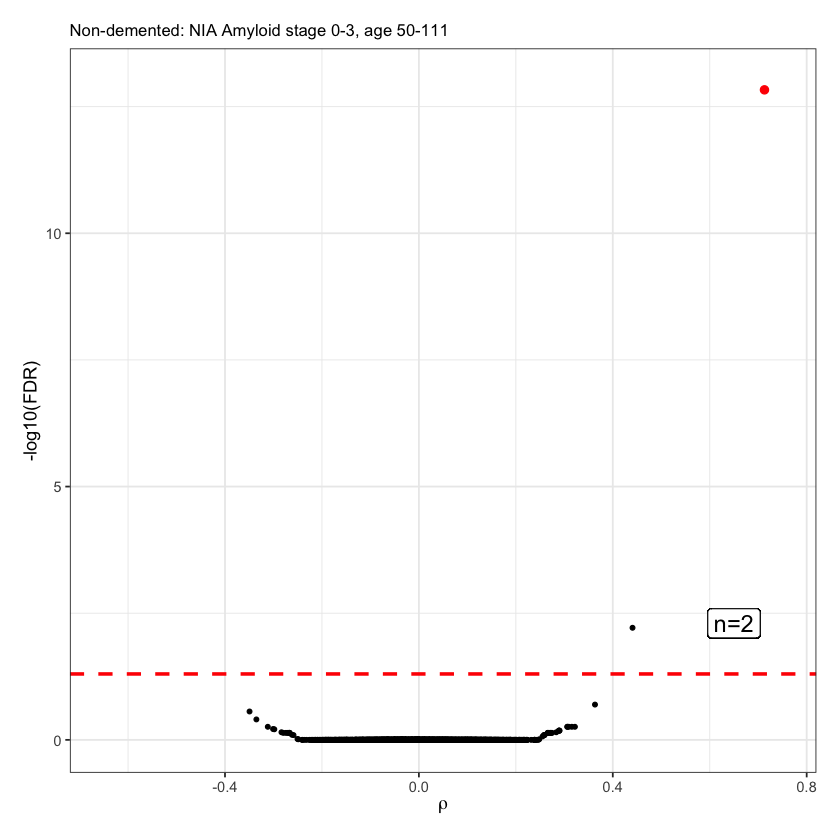

In [25]:
Abeta_plot <- ggplot(Abeta_intens_corr, aes(x = rho, y = -log10(FDR))) + 
    geom_point(aes(color = as.factor(diff), size = as.factor(diff))) + 
    ggtitle("Non-demented: NIA Amyloid stage 0-3, age 50-111") +
    xlab(expression(rho)) + #, " (in ND and centenarian group)"))) +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", 
                color = "red", size=1) +
    geom_label(aes(x=0.65, y=-log10(0.05)+1, label="n=2"),
               color="black", 
               size=5, angle=0) +
    ylim(0, 13) +
    xlim(-0.65, 0.75) +
    #geom_text_repel(aes(label=ifelse(FDR < 0.05, as.character(rownames(Abeta_intens_corr)), '')), 
        #size=4, show.legend = FALSE) +
    scale_color_manual(name="", breaks = c(0, 1),
                       values = c("black", "red")) +
    scale_size_manual(name="", breaks = c(0, 1),
                       values = c(1, 2)) +
    
    theme_bw() + 
    theme(plot.title = element_text(size = title_size),
          legend.position = "none", 
          plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
Abeta_plot

In [33]:
summary(metadata[metadata$GROUP != "AD", ]$age)
summary(metadata[metadata$GROUP != "AD", ]$braak)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   83.25   95.00   91.63  102.00  111.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   2.363   3.000   5.000 

In [34]:
Braak_intens_corr <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                                           corr_test, metadata[test_index, ]$braak, method = "pearson")))
colnames(Braak_intens_corr) <- c("rho", "p")

Braak_intens_corr$FDR <- p.adjust(Braak_intens_corr$p, method = "BH")

In [35]:
sum(Braak_intens_corr$p < 0.05)
sum(Braak_intens_corr$FDR < 0.05)

[1] 524

[1] 76

In [36]:
Braak_NDCEN_index <- which(Braak_intens_corr$FDR < 0.05)

In [37]:
#Braak_intens_corr[rownames(Braak_intens_corr) == "MAPT", ]

In [38]:
Braak_intens_corr <- cbind(rownames(Braak_intens_corr), Braak_intens_corr)

In [31]:
colnames(Braak_intens_corr) <- c("Protein name", "Pearson coefficient (ρ)", "p-values", "FDR")

In [123]:
Braak_intens_corr_NDCEN <- Braak_intens_corr

In [135]:
#Braak_intens_corr[order(Braak_intens_corr$FDR)[1:80], ]

In [75]:
write.table(Braak_intens_corr[order(Braak_intens_corr$FDR)[1:76], ], 
            file = "100_plus_results/Results_for_paper_supplementary/Braak_correlated_proteins76_inNDsamples.tsv",
            col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")

In [39]:
Braak_intens_corr$diff <- 0
Braak_intens_corr[which(rownames(Braak_intens_corr) %in% c("MAPT", "APP")), ]$diff <- 1

Braak_intens_corr <- Braak_intens_corr[order(Braak_intens_corr$diff), ]

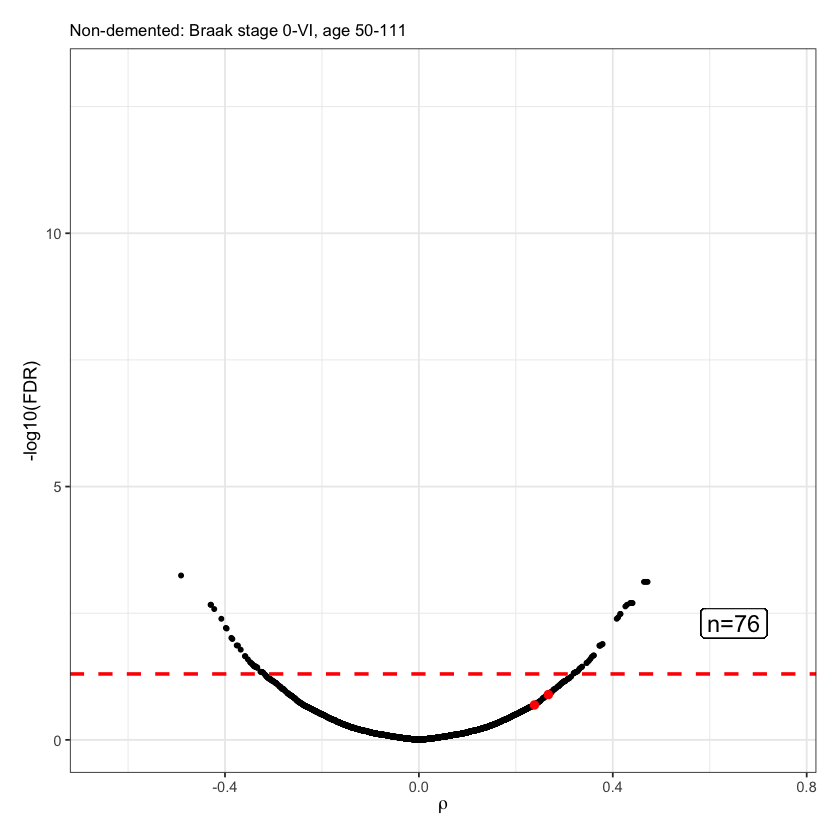

In [40]:
Braak_plot <- ggplot(Braak_intens_corr, aes(x = rho, y = -log10(FDR))) + 
    geom_point(aes(color = as.factor(diff), size = as.factor(diff))) + 
    ggtitle("Non-demented: Braak stage 0-VI, age 50-111") +
    xlab(expression(rho)) + #, " (in ND and centenarian group)"))) +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", 
                color = "red", size=1) +
    geom_label(aes(x=0.65, y=-log10(0.05)+1, label="n=76"),
               color="black", 
               size=5, angle=0) +
    ylim(0, 13) +
    xlim(-0.65, 0.75) +
    scale_color_manual(name="", breaks = c(0, 1),
                       values = c("black", "red")) +
    scale_size_manual(name="", breaks = c(0, 1),
                       values = c(1, 2)) +

    theme_bw() + 
    theme(plot.title = element_text(size = title_size),
          legend.position = "none",
          plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
Braak_plot

In [121]:
#corr_plot <- plot_grid(Abeta_plot, Braak_plot,
#                       align = "hv", axis = "lrtb", labels = c("a", "b"), 
#                       label_size = 12, hjust = -3,
#                       nrow = 1, ncol = 2)

In [122]:
#corr_plot

###  Test correlation with Amyloid stage in AD only

In [41]:
summary(metadata[metadata$GROUP == "AD", ]$age)
summary(metadata[metadata$GROUP == "AD", ]$amyloid)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  55.00   71.75   85.00   81.20   90.00  102.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    3.00    3.00    2.92    3.00    3.00 

In [42]:
test_index <- which((metadata$GROUP == "AD"))
length(test_index)

Abeta_intens_corr <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                         corr_test, metadata[test_index, ]$amyloid, method = "pearson")))
colnames(Abeta_intens_corr) <- c("rho", "p")

Abeta_intens_corr$FDR <- p.adjust(Abeta_intens_corr$p, method = "BH")

sum(Abeta_intens_corr$p < 0.05)
sum(Abeta_intens_corr$FDR < 0.05)

[1] 88

[1] 235

[1] 0

In [43]:
Abeta_intens_corr$diff <- 0
Abeta_intens_corr[which(rownames(Abeta_intens_corr) == "APP"), ]$diff <- 1

Abeta_intens_corr <- Abeta_intens_corr[order(Abeta_intens_corr$diff), ]

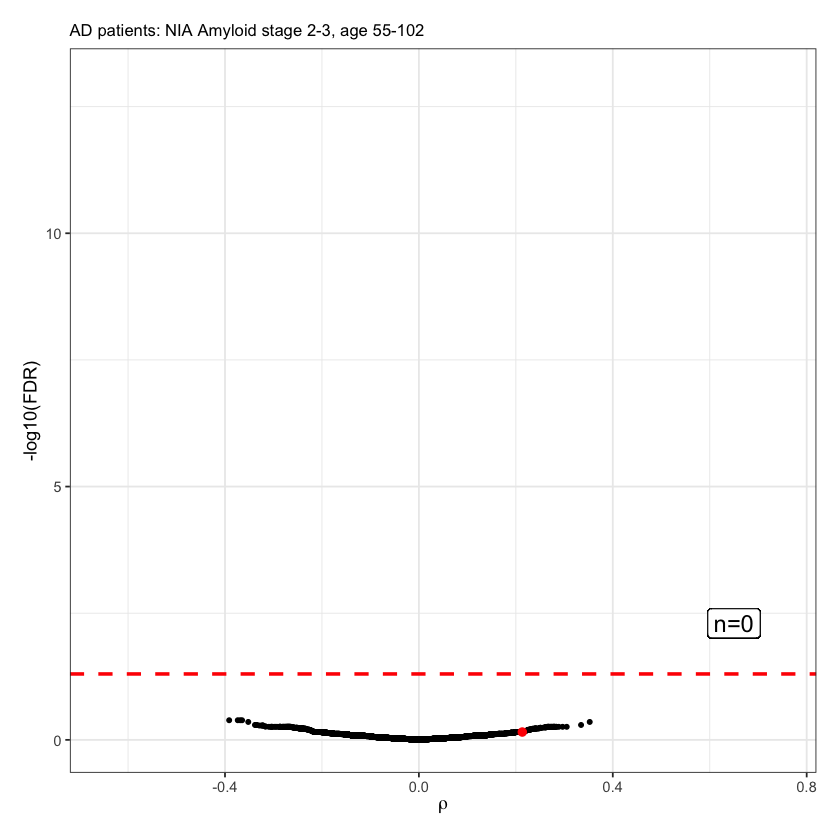

In [44]:
Abeta_plot_inAD <- ggplot(Abeta_intens_corr, aes(x = rho, y = -log10(FDR))) + 
    geom_point(aes(color = as.factor(diff), size = as.factor(diff))) + 
    ggtitle("AD patients: NIA Amyloid stage 2-3, age 55-102") +
    xlab(expression(rho)) + #, " (in AD group)"))) +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", 
                color = "red", size=1) +
    geom_label(aes(x=0.65, y=-log10(0.05)+1, label="n=0"),
               color="black", 
               size=5, angle=0) +
    ylim(0, 13) +
    xlim(-0.65, 0.75) +
    scale_color_manual(name="", breaks = c(0, 1),
                       values = c("black", "red")) +
    scale_size_manual(name="", breaks = c(0, 1),
                       values = c(1, 2)) +
    
    theme_bw() + 
    theme(plot.title = element_text(size = title_size),
          legend.position = "none",
          plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
Abeta_plot_inAD

In [45]:
summary(metadata[metadata$GROUP == "AD", ]$age)
summary(metadata[metadata$GROUP == "AD", ]$braak)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  55.00   71.75   85.00   81.20   90.00  102.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.000   5.000   5.000   5.057   6.000   6.000 

In [46]:
test_index <- which((metadata$GROUP == "AD"))
length(test_index)

table(metadata[test_index, ]$braak)

Braak_intens_corr <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                                           corr_test, metadata[test_index, ]$braak, method = "pearson")))
colnames(Braak_intens_corr) <- c("rho", "p")

Braak_intens_corr$FDR <- p.adjust(Braak_intens_corr$p, method = "BH")

sum(Braak_intens_corr$p < 0.05)
sum(Braak_intens_corr$FDR < 0.05)

[1] 88


 4  5  6 
20 43 25 

[1] 1513

[1] 1204

In [47]:
Braak_AD_index <- which(Braak_intens_corr$FDR < 0.05)

In [48]:
Braak_intens_corr <- cbind(rownames(Braak_intens_corr), Braak_intens_corr)

In [44]:
colnames(Braak_intens_corr) <- c("Protein name", "Pearson coefficient (ρ)", "p-values", "FDR")

In [134]:
#Braak_intens_corr[order(Braak_intens_corr$FDR)[1:1205], ]

In [85]:
write.table(Braak_intens_corr[order(Braak_intens_corr$FDR)[1:1204], ], 
            file = "100_plus_results/Results_for_paper_supplementary/Braak_correlated_proteins1204_inADpatients.tsv",
            col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")

In [136]:
#Braak_intens_corr_ALL <- cbind(Braak_intens_corr_NDCEN, Braak_intens_corr)
#Braak_intens_corr_ALL
#Braak_intens_corr_ALL[intersect(Braak_AD_index, Braak_NDCEN_index), ]

In [133]:
write.table(Braak_intens_corr_ALL[intersect(Braak_AD_index, Braak_NDCEN_index), ], 
            file = "100_plus_results/Results_for_paper_supplementary/Braak_correlated_proteins76_and_1204_overlap.tsv",
            col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")

In [49]:
Braak_intens_corr$diff <- 0
Braak_intens_corr[which(rownames(Braak_intens_corr) %in% c("MAPT", "APP")), ]$diff <- 1

Braak_intens_corr <- Braak_intens_corr[order(Braak_intens_corr$diff), ]

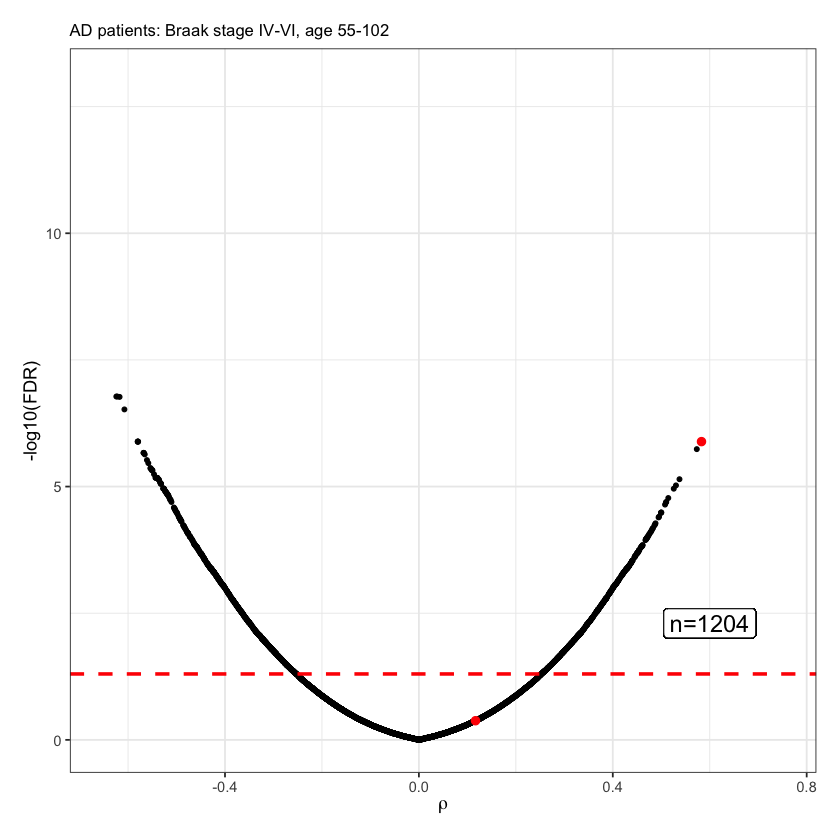

In [50]:
Braak_plot_inAD <- ggplot(Braak_intens_corr, aes(x = rho, y = -log10(FDR))) + 
    geom_point(aes(color = as.factor(diff), size = as.factor(diff))) + 
    ggtitle("AD patients: Braak stage IV-VI, age 55-102") +
    xlab(expression(rho)) + #, " (in AD group)"))) +
    geom_hline(yintercept = -log10(0.05), linetype="dashed", 
                color = "red", size=1) +
    geom_label(aes(x=0.6, y=-log10(0.05)+1, label="n=1204"),
               color="black", 
               size=5, angle=0) +
    ylim(0, 13) +
    xlim(-0.65, 0.75) +
    scale_color_manual(name="", breaks = c(0, 1),
                       values = c("black", "red")) +
    scale_size_manual(name="", breaks = c(0, 1),
                       values = c(1, 2)) +

    theme_bw() + 
    theme(plot.title = element_text(size = title_size),
          legend.position = "none",
          plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
Braak_plot_inAD

In [85]:
corr_plot <- plot_grid(Braak_plot, Braak_plot_inAD, Abeta_plot, Abeta_plot_inAD, 
                       align = "hv", axis = "lrtb", labels = c("A", "B", "C", "D"), 
                       label_size = 12, hjust = 0, vjust = 2.5,
                       nrow = 2, ncol = 2)

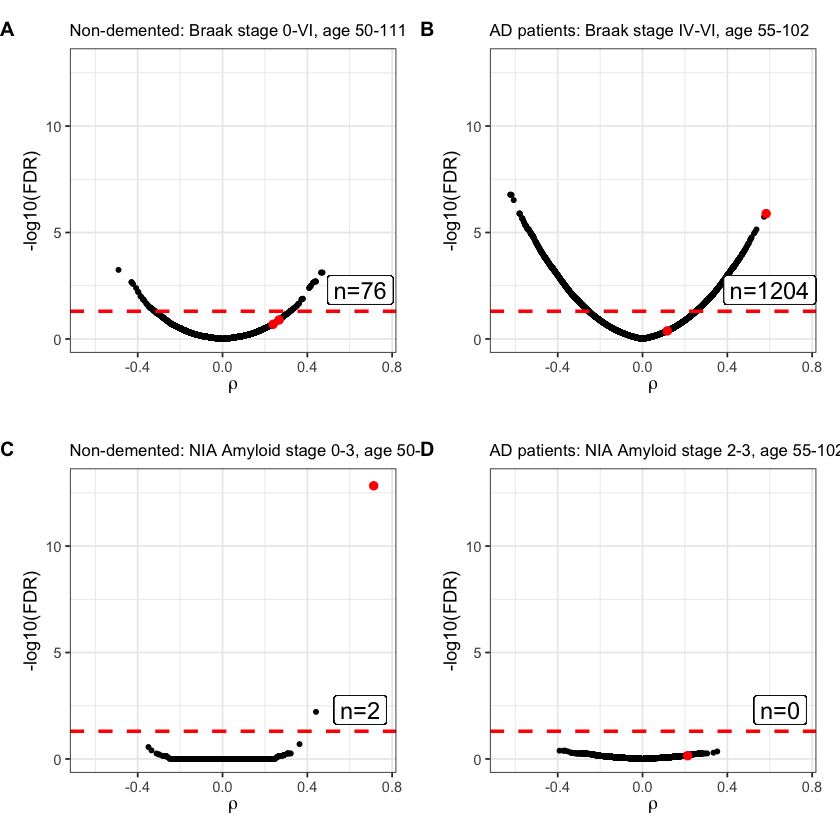

In [86]:
corr_plot

In [58]:
save_plot("100_plus_plots/proteomics/Protein_correlation_with_Braak_Amyloid_inNonDandAD_20230104.pdf", 
          corr_plot, base_height = 8, base_width = 8)

In [61]:
load(file = "100_plus_plots/proteomics/APPCD44_age_plot.Rdata")

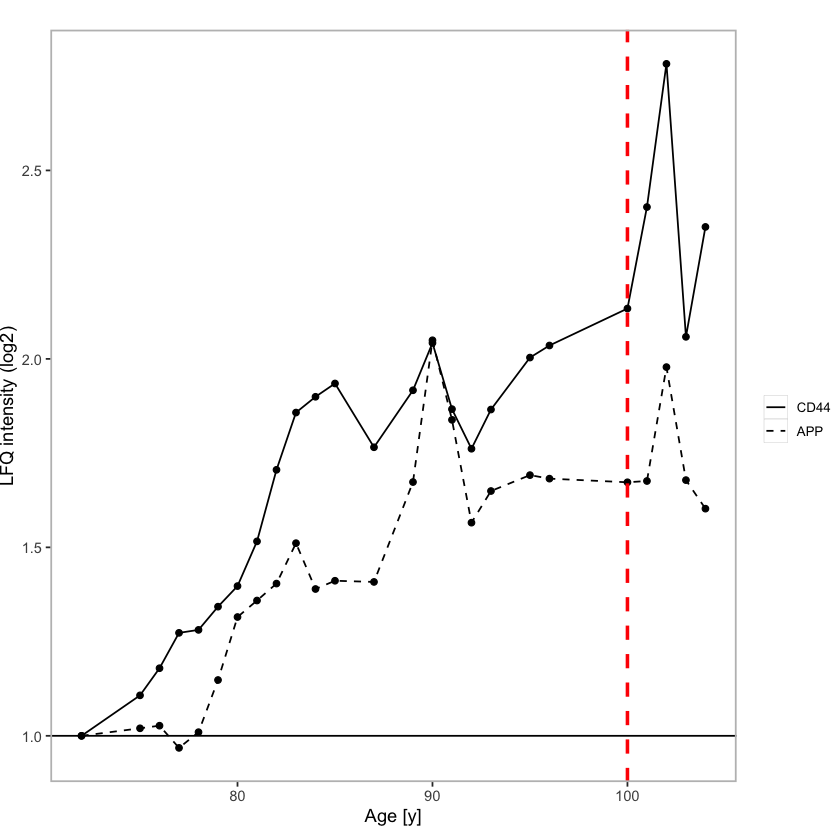

In [62]:
APPCD44_plot

In [63]:
load(file = "100_plus_plots/proteomics/Abeta_distribution_plot.Rdata")

In [64]:
Abeta_corr_plot <- plot_grid(Abeta_distr_plot[[1]], Abeta_distr_plot[[2]], Abeta_distr_plot[[1]],
                             Abeta_plot_inAD, Abeta_plot, APPCD44_plot,
          align = "hv", axis = "lrtb", labels = c(LETTERS[1:2], "", LETTERS[3:5]), 
          label_size = 12, hjust = 0, vjust = 2.5,
          nrow = 2, ncol = 3)

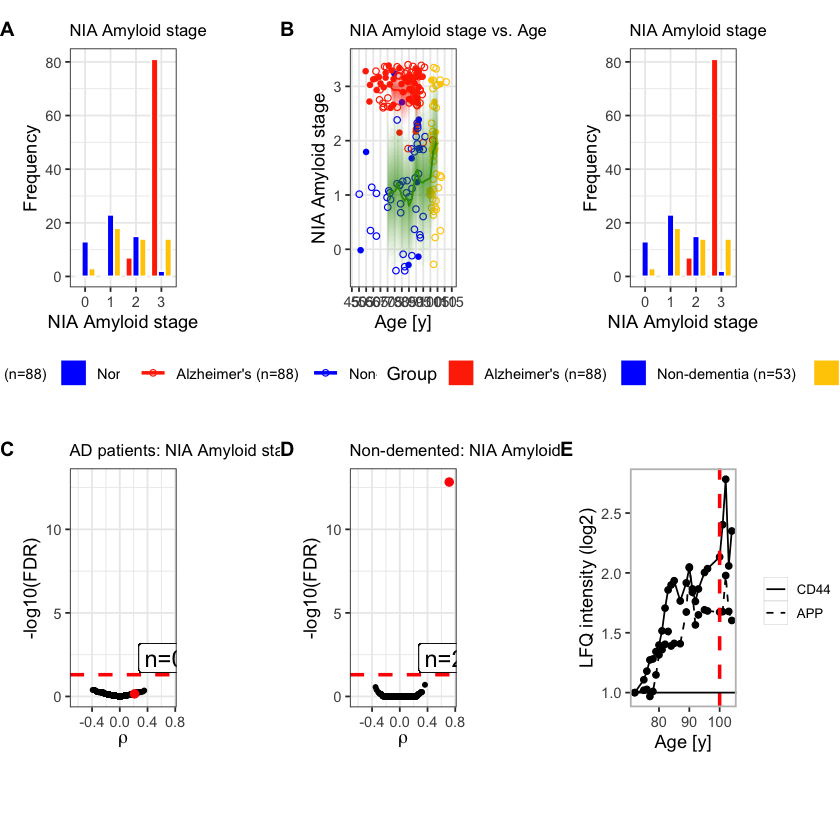

In [65]:
Abeta_corr_plot

In [66]:
save_plot("100_plus_plots/proteomics/Distribution_and_correlation_with_Amyloid_in3groups_20230221.pdf", 
          Abeta_corr_plot, base_height = 8, base_width = 12)

In [67]:
load(file = "100_plus_plots/proteomics/Braak_distribution_plot.Rdata")

In [68]:
Braak_corr_plot <- plot_grid(Braak_distr_plot[[1]], Braak_distr_plot[[2]], 
                             Braak_plot_inAD, Braak_plot, 
          align = "hv", axis = "lrtb", labels = LETTERS[1:4], 
          label_size = 12, hjust = 0, vjust = 2.5,
          nrow = 2, ncol = 2)

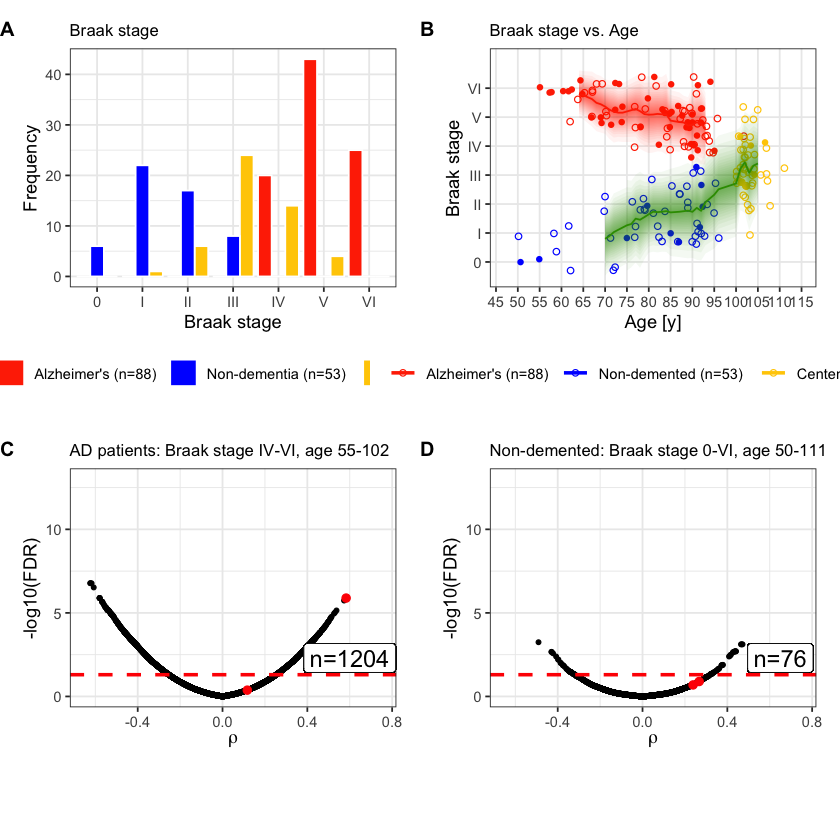

In [69]:
Braak_corr_plot

In [70]:
save_plot("100_plus_plots/proteomics/Distribution_and_correlation_with_Braak_in3groups_20230221.pdf", 
          Braak_corr_plot, base_height = 8, base_width = 7)

In [11]:
path <- "iQTL_result/data/peptide_quality-after_sample_filtering.tsv"
raw_data <- read.table(path, header = T, stringsAsFactors = F, sep = "\t")
peptide_quality <- raw_data[, grep("qvalue_", colnames(raw_data))]

path <- "iQTL_result/data/peptide_intensity-after_sample_filtering.tsv"
raw_data <- read.table(path, header = T, stringsAsFactors = F, sep = "\t")
peptide_info <- raw_data[, c(1, 2)]
peptide_intensity <- raw_data[, grep("intensity_", colnames(raw_data))]

In [12]:
log2_peptide_intensity <- log2(peptide_intensity)
dim(peptide_intensity)

[1] 28191   190

In [27]:
log2_peptide_intensity

intensity_20190325_121_S16_020_CHC_011,intensity_20190325_125_S16_044_CHC_007,intensity_20190325_127_S16_094_CHC_004,intensity_20190325_16_04_037_AD_008,intensity_20190325_183_S10_292_AD_010,intensity_20190325_194_S02_055_ND_005,intensity_20190325_31_01_184_AD_006,intensity_20190325_57_S97_235_AD_003,intensity_20190325_77_S11_072_ND_012,intensity_20190325_79_S07_308_ND_009,⋯,intensity_20190507_21_01_032_AD_221,intensity_20190507_27_00_204_AD_211,intensity_20190507_29_S99_240_AD_219,intensity_20190507_30_S05_040_AD_209,intensity_20190507_63_04_027_AD_217,intensity_20190507_72_S99_219_AD_213,intensity_20190606_106_NABCA14_08_ND_RERUN,intensity_20190606_140_2017_027_CHC_RERUN,intensity_20190606_20_S00_166_AD_RERUN,intensity_20190606_9_S93_025_AD_RERUN
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.9153376,6.999040,6.0487262,6.3531071,7.3059249,7.4467909,6.7413830,6.6910311,6.3570819,7.255736,⋯,6.8755142,7.080655193,6.5747357,6.6531015,6.8729057,6.8612917,7.1455058,6.807762,6.9477105,6.9535112
6.2632617,6.325269,6.4081504,5.7993926,5.2123756,6.4457061,4.9657702,5.8617733,6.0943984,5.929136,⋯,6.0649926,4.768976896,6.3737830,6.8043441,6.2423794,6.6453225,7.5668597,7.418389,7.1969401,7.5738107
4.6790534,5.104199,5.1544903,4.6571326,3.8641009,5.0022786,3.5218752,4.6290711,4.7115018,4.469022,⋯,4.8037589,3.164446507,4.5060115,5.5453224,4.5331778,5.0534730,5.7487919,5.324418,5.6011351,5.2926992
3.1910711,3.697390,1.8717061,3.2820057,3.2710657,2.6656873,1.9265677,3.3201659,2.6691354,2.344975,⋯,3.6883570,2.157463307,3.2703330,4.5927253,3.6246200,4.9703098,1.0398173,2.929041,3.1354427,3.9258554
2.0943161,0.000000,0.3566532,0.2558710,0.0000000,0.0000000,0.1182703,0.0000000,2.5828678,0.000000,⋯,0.0000000,1.224698714,1.3058303,0.0000000,1.1277329,0.4521352,0.0000000,0.000000,0.8544744,1.2246426
2.6526102,3.488621,4.1995837,1.8904052,6.3343245,4.8698906,4.9703351,5.1373299,3.3234509,4.459351,⋯,3.2604892,5.203377325,3.1760172,2.9579726,4.8917568,3.8700198,4.2445158,4.569146,4.1899838,4.8482053
6.7511507,7.602751,7.8500787,7.1239544,7.1073868,5.8592515,7.1895410,7.3748747,7.2749848,7.122278,⋯,7.6373527,7.261589542,7.7705526,7.1777630,7.4346752,7.8396451,8.3770275,8.244730,7.9296413,8.4190611
3.1558084,4.377228,4.4929229,3.5080595,3.1848436,2.8769528,3.3030261,3.7101196,2.8551217,4.066161,⋯,2.3044375,2.488826885,2.7227018,2.5197806,3.3261236,3.0634464,3.9237615,2.869004,3.1055816,1.8190390
4.5732072,5.024244,5.4574202,3.8161043,5.6808623,3.9298104,5.6038615,6.2706839,5.0817186,5.835510,⋯,5.3283269,3.705094566,5.6640100,4.3723218,4.8517642,5.8998023,6.4430209,6.385038,5.3608818,6.2872200


In [13]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,A,0.6,6.166667
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,C,1.0,5.283333
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,A,1.0,7.916667
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,C,1.0,5.916667
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,C,0.6,4.583333
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,C,2.6,5.500000
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,C,1.0,5.083333
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,C,3.2,2.000000
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,O,1.0,7.250000


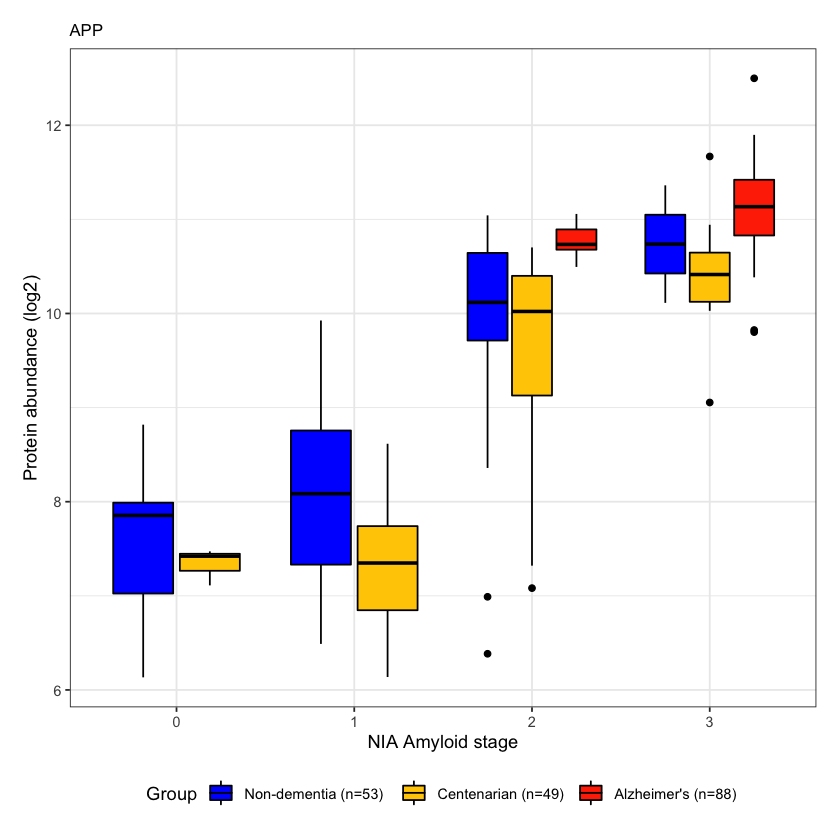

In [23]:
temp_prot <- data.frame(Abeta = as.factor(round(metadata$amyloid)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[rownames(protein_intensity_combat) == "APP",]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "CHC", "AD"))

xlabels <- sort(unique(temp_prot$Abeta))
APP_plot <- ggplot(#subset(temp_prot, group != "AD"), 
                   temp_prot,
                   aes(x = Abeta, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("NIA Amyloid stage") +
    ylab("Protein abundance (log2)") +
    ggtitle("APP") +
    scale_x_discrete(breaks=xlabels, labels = c("0", "1", "2", "3")) +

    scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                      values = c(color_ND, color_CHC, color_AD), 
                      labels = c("Non-dementia (n=53)", 
                                 "Centenarian (n=49)",
                                 "Alzheimer's (n=88)"
                                 )) +
    theme_bw() + theme(legend.position = "bottom",
                       plot.title = element_text(size = title_size),
                       plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm")) 
    
APP_plot

In [24]:
peptide_info[which(peptide_info$protein == "APP"), ]

,peptide_id,protein
,<chr>,<chr>
2402,_C[Carbamidomethyl (C)]LVGEFVSDALLVPDK_.3,APP
6192,_EQNYSDDVLANM[Oxidation (M)]ISEPR_.3,APP
16329,_LVFFAEDVGSNK_.2,APP
22096,_STNLHDYGM[Oxidation (M)]LLPC[Carbamidomethyl (C)]GIDK_.3,APP
24617,_VESLEQEAANER_.2,APP
27277,_YLETPGDENEHAHFQK_.4,APP


In [25]:
get_peptide_sequence <- function(peptide){
    clean_peptide <- unlist(strsplit(peptide, split = "\\_"))[2]
    clean_peptide <- str_remove_all(clean_peptide, "\\[.+?\\]")
    return(clean_peptide)
}

In [26]:
target_peptide_plot <- list()
j <- 1

for(i in which(peptide_info$protein == "APP")){
    plot_data <- data.frame(intens = as.numeric(log2_peptide_intensity[i, ]),
                            braak = as.factor(metadata$fBraak),
                            Abeta = as.factor(round(metadata$amyloid)),
                            group = metadata$GROUP)
    
    plot_data$group <- factor(plot_data$group, levels=c("ND", "CHC", "AD"))
    xlabels <- sort(unique(plot_data$braak))
    
    p <- ggplot(plot_data, aes(x = Abeta, y = intens, fill = group))+
            geom_boxplot(color = "black") +
            xlab("NIA Amyloid stage") +
            ylab("LFQ intensity (log2)") +
            ggtitle(get_peptide_sequence(peptide_info[i, ]$peptide_id)) +
            #scale_x_discrete(breaks=xlabels, labels = c("I", "II", "III", "IV", "V", "VI")) +
        
            scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                               values = c(color_ND, color_CHC, color_AD))+
        
            theme_bw() + theme(legend.position = "none",
                               plot.title = element_text(size = title_size), 
                               plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
    target_peptide_plot[[j]] <- p
    j  <- j + 1
}

In [27]:
p <- plot_grid(plotlist = target_peptide_plot, ncol = 3, label_size = 12, hjust = 0, vjust = 2.5,
               labels = LETTERS[1:length(target_peptide_plot)])

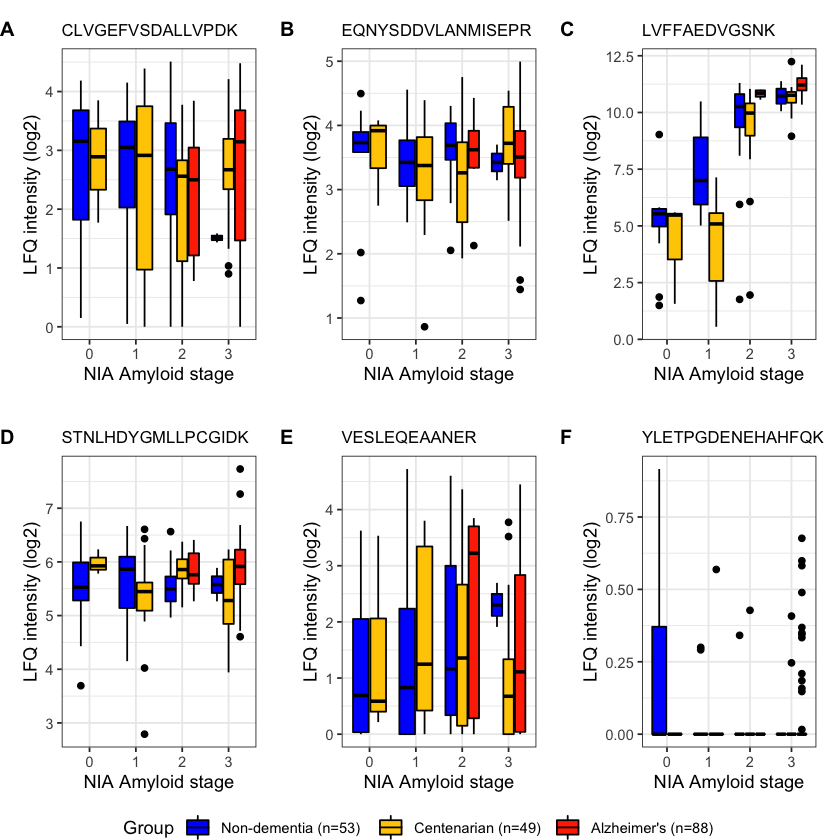

In [28]:
legend <- get_legend(APP_plot)
APP_peptides_plot <- plot_grid(p, legend, align = "v", axis = "r", rel_heights = c(0.97, 0.03), nrow = 2)
APP_peptides_plot

In [29]:
save_plot("100_plus_plots/proteomics/APP_peptide_correlation_with_amyloid_20221204.pdf", 
          APP_peptides_plot, base_height = 6, base_width = 9)

In [182]:
legend <- get_legend(APP_plot)

In [183]:
APP_peptide_plot <- plot_grid(APP_plot + theme(legend.position='none'), target_peptide_plot[[3]], target_peptide_plot[[4]],
                      align = "hv", axis = "lrtb", labels = c("A", "B", "C"), 
                      label_size = 12, hjust = 0, vjust = 2.5,
                      nrow = 1, ncol = 3)

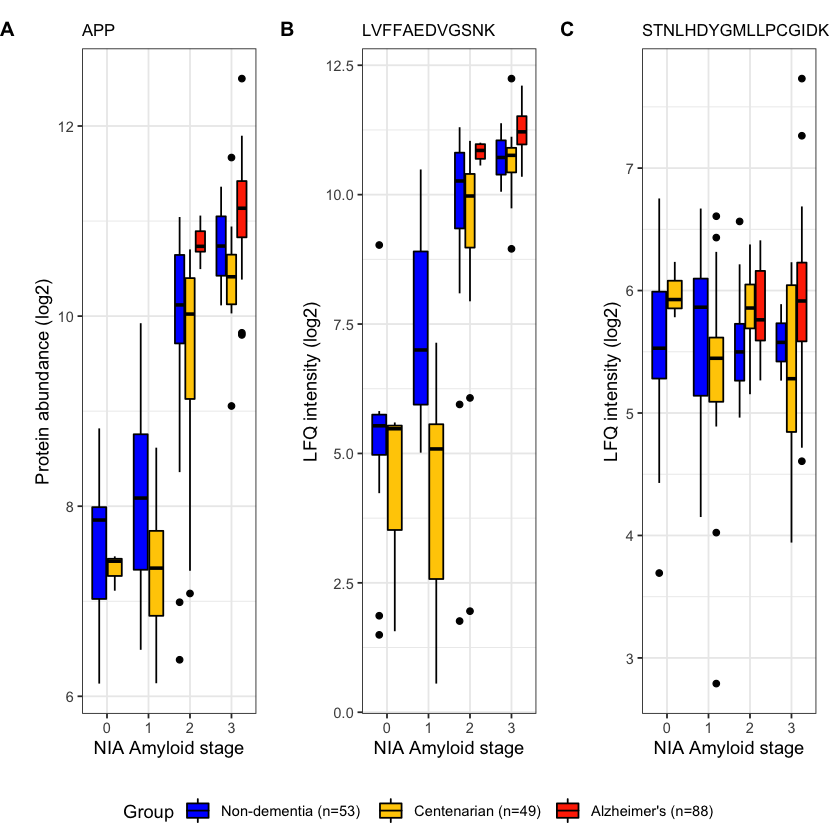

In [185]:
Amyloid_plot <- plot_grid(APP_peptide_plot, legend, align = "v", axis = "r", rel_heights = c(0.93, 0.07), nrow = 2)
Amyloid_plot

In [187]:
save_plot("100_plus_plots/proteomics/APP_and_APP_peptidea_20221204.pdf", 
          Amyloid_plot, base_height = 3, base_width = 9)

In [125]:
all_plot <- plot_grid(corr_plot, Amyloid_plot, align = "v", rel_heights = c(0.7, 0.3), 
                      nrow = 2)
#all_plot

In [126]:
save_plot("100_plus_plots/proteomics/Protein_correlation_with_Braak_Amyloid_inND_AD_and Amyloid_peptide_20221119.pdf", 
          all_plot, base_height = 10, base_width = 9)

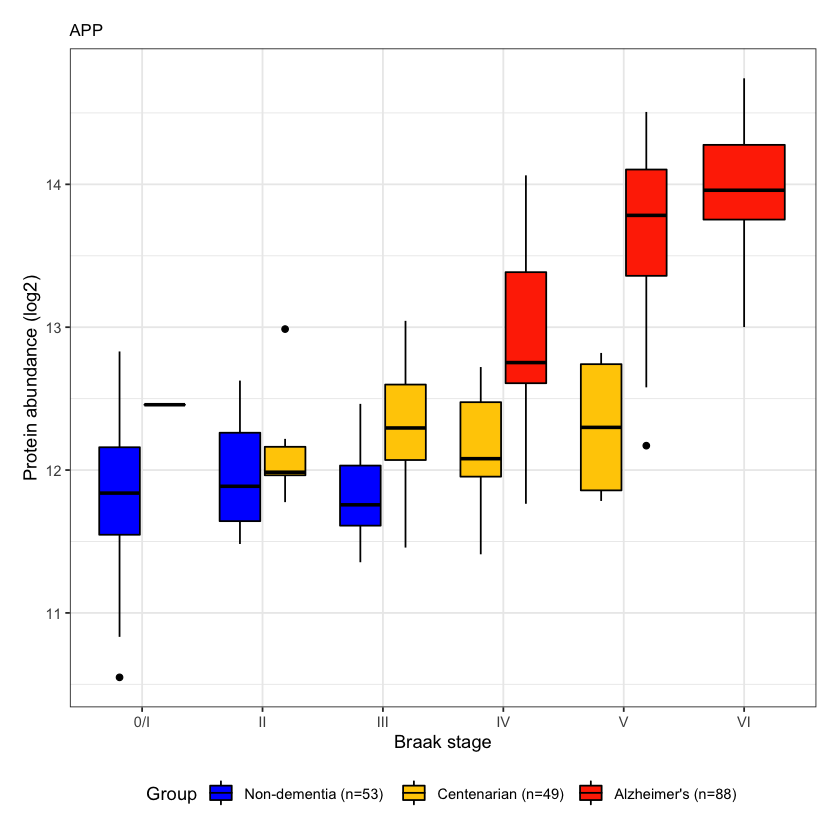

In [30]:
temp_prot <- data.frame(Abeta = as.factor(round(metadata$fBraak)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[rownames(protein_intensity_combat) == "MAPT",]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "CHC", "AD"))

xlabels <- sort(unique(temp_prot$Abeta))
MAPT_plot <- ggplot(temp_prot,
                    aes(x = Abeta, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("Protein abundance (log2)") +
    ggtitle("APP") +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                      values = c(color_ND, color_CHC, color_AD), 
                      labels = c("Non-dementia (n=53)", 
                                 "Centenarian (n=49)",
                                 "Alzheimer's (n=88)"
                                 )) +
    theme_bw() + theme(legend.position = "bottom",
                       plot.title = element_text(size = title_size),
                       plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm")) 
    
MAPT_plot

In [14]:
peptide_info[which(peptide_info$protein == "MAPT"), ]

,peptide_id,protein
,<chr>,<chr>
10154,_HVPGGGSVQIVYKPVDLSK_.3,MAPT
10155,_HVPGGGSVQIVYKPVDLSK_.4,MAPT
10877,_IGSLDNITHVPGGGNKK_.3,MAPT
10878,_IGSLDNITHVPGGGNK_.3,MAPT
13310,_LDLSNVQSK_.2,MAPT
15684,_LQTAPVPM[Oxidation (M)]PDLKNVK_.3,MAPT
15685,_LQTAPVPM[Oxidation (M)]PDLK_.2,MAPT
19019,_QEFEVM[Oxidation (M)]EDHAGTYGLGDRK_.3,MAPT
19020,_QEFEVM[Oxidation (M)]EDHAGTYGLGDRK_.4,MAPT


In [15]:
peptide_ID <- peptide_info[which(peptide_info$protein == "MAPT"), ]$peptide_id

In [16]:
peptide_ID

[1] "_HVPGGGSVQIVYKPVDLSK_.3"               
 [2] "_HVPGGGSVQIVYKPVDLSK_.4"               
 [3] "_IGSLDNITHVPGGGNKK_.3"                 
 [4] "_IGSLDNITHVPGGGNK_.3"                  
 [5] "_LDLSNVQSK_.2"                         
 [6] "_LQTAPVPM[Oxidation (M)]PDLKNVK_.3"    
 [7] "_LQTAPVPM[Oxidation (M)]PDLK_.2"       
 [8] "_QEFEVM[Oxidation (M)]EDHAGTYGLGDRK_.3"
 [9] "_QEFEVM[Oxidation (M)]EDHAGTYGLGDRK_.4"
[10] "_QEFEVM[Oxidation (M)]EDHAGTYGLGDR_.3" 
[11] "_STPTAEAEEAGIGDTPSLEDEAAGHVTQAR_.4"    
[12] "_TPSLPTPPTREPK_.2"                     
[13] "_TPSLPTPPTREPK_.3"                     
[14] "_TPSLPTPPTR_.2"                        
[15] "_VQIVYKPVDLSK_.2"                      
[16] "_VQIVYKPVDLSK_.3"

In [17]:
get_peptide_sequence <- function(peptide){
    clean_peptide <- unlist(strsplit(peptide, split = "\\_"))[2]
    clean_peptide <- str_remove_all(clean_peptide, "\\[.+?\\]")
    return(clean_peptide)
}

peptide_sequences <- as.character(lapply(peptide_ID, get_peptide_sequence))

peptide_sequences_unique <- unique(peptide_sequences)

In [18]:
peptide_sequences

[1] "HVPGGGSVQIVYKPVDLSK"            "HVPGGGSVQIVYKPVDLSK"           
 [3] "IGSLDNITHVPGGGNKK"              "IGSLDNITHVPGGGNK"              
 [5] "LDLSNVQSK"                      "LQTAPVPMPDLKNVK"               
 [7] "LQTAPVPMPDLK"                   "QEFEVMEDHAGTYGLGDRK"           
 [9] "QEFEVMEDHAGTYGLGDRK"            "QEFEVMEDHAGTYGLGDR"            
[11] "STPTAEAEEAGIGDTPSLEDEAAGHVTQAR" "TPSLPTPPTREPK"                 
[13] "TPSLPTPPTREPK"                  "TPSLPTPPTR"                    
[15] "VQIVYKPVDLSK"                   "VQIVYKPVDLSK"

In [19]:
peptide_sequences_unique

[1] "HVPGGGSVQIVYKPVDLSK"            "IGSLDNITHVPGGGNKK"             
 [3] "IGSLDNITHVPGGGNK"               "LDLSNVQSK"                     
 [5] "LQTAPVPMPDLKNVK"                "LQTAPVPMPDLK"                  
 [7] "QEFEVMEDHAGTYGLGDRK"            "QEFEVMEDHAGTYGLGDR"            
 [9] "STPTAEAEEAGIGDTPSLEDEAAGHVTQAR" "TPSLPTPPTREPK"                 
[11] "TPSLPTPPTR"                     "VQIVYKPVDLSK"

In [38]:
MAPT_peptide_intens  <- NULL

for(seq in peptide_sequences_unique){
    log2_peptide_intensity_MAPTsub <- log2_peptide_intensity[which(peptide_info$protein == "MAPT")[which(peptide_sequences == seq)], ]
    #print(log2_peptide_intensity_MAPTsub)
    MAPT_peptide_intens <- rbind(MAPT_peptide_intens, as.numeric(colSums(log2_peptide_intensity_MAPTsub)))
}

In [39]:
MAPT_peptide_intens <- as.data.frame(MAPT_peptide_intens, row.names = peptide_sequences_unique)
colnames(MAPT_peptide_intens) <- metadata$nbb

In [42]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,A,0.6,6.166667
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,C,1.0,5.283333
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,A,1.0,7.916667
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,C,1.0,5.916667
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,C,0.6,4.583333
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,C,2.6,5.500000
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,C,1.0,5.083333
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,C,3.2,2.000000
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,O,1.0,7.250000


In [40]:
MAPT_peptide_intens

,2016-020,2016-044,2016-094,2004-011,2010-101,2002-024,2001-081,1997-091,2011-072,2007-082,⋯,2001-008,2000-097,1999-112,2005-011,2004-006,1999-102,777,2017-027,2000-076,1993-014
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HVPGGGSVQIVYKPVDLSK,15.283114,14.9173170,15.286936,19.719106,20.274037,15.468453,18.908583,18.335085,14.400814,13.819684,⋯,17.102035,18.199688,21.479180,17.634012923,18.487374,19.142165,18.287181,18.989388,17.4672205,20.888052
IGSLDNITHVPGGGNKK,4.835596,0.9768718,4.230003,6.980559,6.444581,4.942570,7.292686,5.526507,2.848264,3.025946,⋯,5.466176,6.025302,6.488826,4.045366206,5.003031,5.027722,3.032562,4.112269,2.6382272,5.841325
IGSLDNITHVPGGGNK,8.534770,8.8473602,9.024272,11.269684,11.704585,8.811085,11.418567,10.676842,8.284258,8.260665,⋯,10.090263,10.580188,12.104992,9.884206127,10.524720,11.108860,8.335986,8.822867,9.5186713,10.328689
LDLSNVQSK,0.000000,2.8743866,4.138363,3.586348,2.717638,1.355214,3.600678,3.472045,0.000000,3.506343,⋯,3.051775,2.648622,4.316460,0.006277495,3.363076,2.905802,2.716016,3.218115,0.3497921,5.405653
LQTAPVPMPDLKNVK,3.367273,3.4515163,3.107906,1.233835,4.612710,3.243058,5.378582,4.591228,3.145153,3.390391,⋯,4.273819,2.774618,6.444438,4.292707142,4.108585,4.893696,5.016967,2.388800,4.6791355,3.687505
LQTAPVPMPDLK,10.430437,10.9660630,11.493046,12.667019,12.670563,10.923422,12.413025,12.518639,10.264097,10.176504,⋯,11.865525,11.946729,13.379267,11.418038667,12.029113,12.884560,11.176337,11.582822,11.5767548,13.461210
QEFEVMEDHAGTYGLGDRK,9.031766,9.4710482,9.968321,11.966164,10.645778,5.968286,9.744524,9.807863,7.495065,6.793404,⋯,8.058071,8.363320,13.155693,11.462820220,10.058072,12.116883,12.949089,12.823478,10.9890227,12.967041
QEFEVMEDHAGTYGLGDR,5.033208,5.2784621,6.008082,7.278019,5.925444,4.328666,5.340770,6.274873,4.418050,3.427157,⋯,5.165481,4.249284,7.201950,6.404479666,5.658821,6.770727,8.001843,7.756835,6.7920610,7.446468
STPTAEAEEAGIGDTPSLEDEAAGHVTQAR,3.697852,4.5835553,4.770202,5.105817,3.386196,3.844175,3.911426,5.071748,3.262048,3.213056,⋯,2.276029,3.217438,4.540599,4.929847193,3.332839,4.425968,5.571819,5.899594,5.1199932,5.561772


In [41]:
save(MAPT_peptide_intens, 
     file = "R_workstation/Centenarian_specific_protemoics_data_analysis_archive/Data_file/MAPT_peptide_intens.Rdata")

In [58]:
MAPT_peptide_plot <- list()
j <- 1

for(seq in peptide_sequences_unique){
    log2_peptide_intensity_MAPTsub <- log2_peptide_intensity[which(peptide_info$protein == "MAPT")[which(peptide_sequences == seq)], ]
    #print(log2_peptide_intensity_MAPTsub)
    plot_data <- data.frame(intens = as.numeric(colSums(log2_peptide_intensity_MAPTsub)),
                            braak = as.factor(metadata$fBraak),
                            Abeta = as.factor(round(metadata$amyloid)),
                            group = metadata$GROUP)
    
    plot_data$group <- factor(plot_data$group, levels=c("ND", "CHC", "AD"))
    xlabels <- sort(unique(plot_data$braak))
    
    p <- ggplot(plot_data, aes(x = braak, y = intens, fill = group))+
            geom_boxplot(color = "black") +
            xlab("Braak stage") +
            ylab("LFQ intensity (log2)") +
            ggtitle(seq) +
            scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
        
            scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                               values = c(color_ND, color_CHC, color_AD))+
        
            theme_bw() + theme(legend.position = "none",
                               plot.title = element_text(size = title_size), 
                               plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm"))
    MAPT_peptide_plot[[j]] <- p
    j  <- j + 1
}

In [59]:
p <- plot_grid(plotlist = MAPT_peptide_plot, ncol = 3, label_size = 12, hjust = 0, vjust = 2.5,
               labels = LETTERS[1:length(MAPT_peptide_plot)])

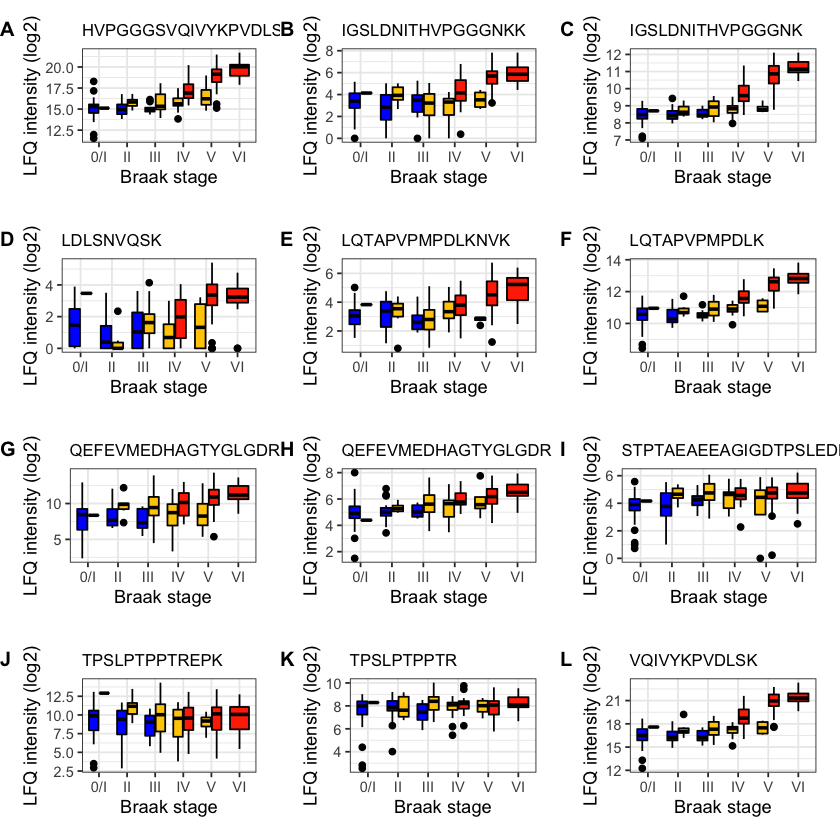

In [60]:
p

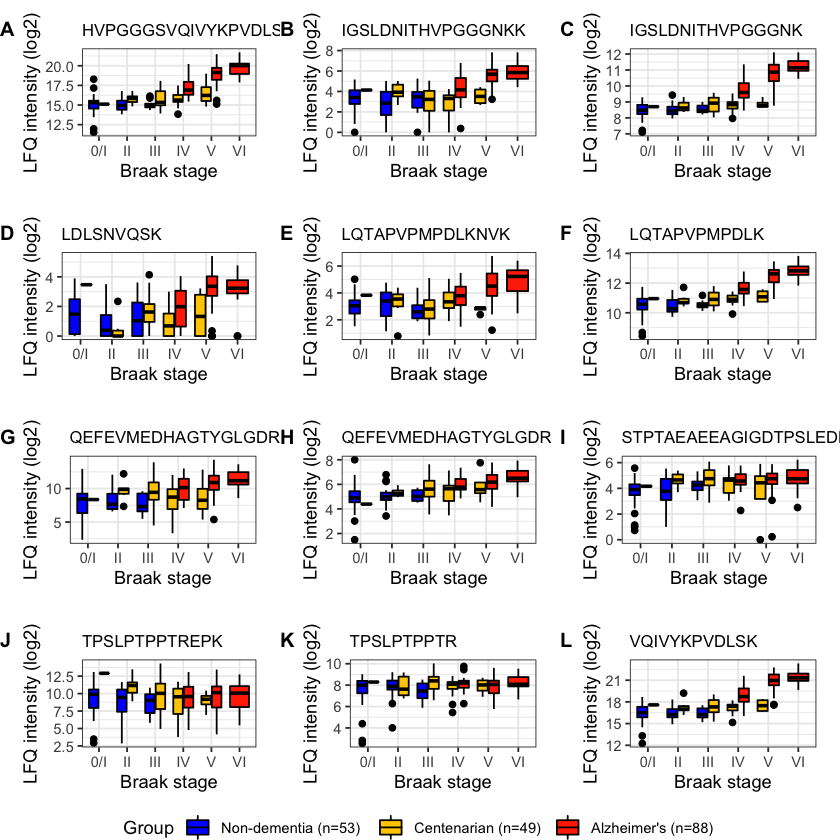

In [61]:
legend <- get_legend(MAPT_plot)
MAPT_peptides_plot <- plot_grid(p, legend, align = "v", axis = "r", rel_heights = c(0.97, 0.03), nrow = 2)
MAPT_peptides_plot

In [62]:
save_plot("100_plus_plots/proteomics/MAPT_peptide_correlation_with_Braakstage_20230404.pdf", 
          MAPT_peptides_plot, base_height = 12, base_width = 9)

In [94]:
Abeta_related_proteins_ANOVA <- as.data.frame(apply(protein_intensity_combat[, test_index], 1, 
                                                    cal_ANOVA_test, metadata[test_index, ]$famyloid))
colnames(Abeta_related_proteins_ANOVA) <- c("p_value")
Abeta_related_proteins_ANOVA$adjusted_p_value <- p.adjust(Abeta_related_proteins_ANOVA$p_value,
                                                              method="BH")

In [95]:
Abeta_related_proteins_ANOVA[order(Abeta_related_proteins_ANOVA$adjusted_p_value), ]

,p_value,adjusted_p_value
,<dbl>,<dbl>
APP,2.893582e-05,0.09977069
SLC12A2,6.840387e-01,0.99990360
CASKIN1,8.837453e-01,0.99990360
GNG2,2.242761e-01,0.99990360
CARNS1,8.925142e-01,0.99990360
FH,8.851315e-01,0.99990360
EFHD2,6.345222e-01,0.99990360
PCLO,9.954655e-01,0.99990360
HSPA1A;HSPA1B,3.442138e-01,0.99990360


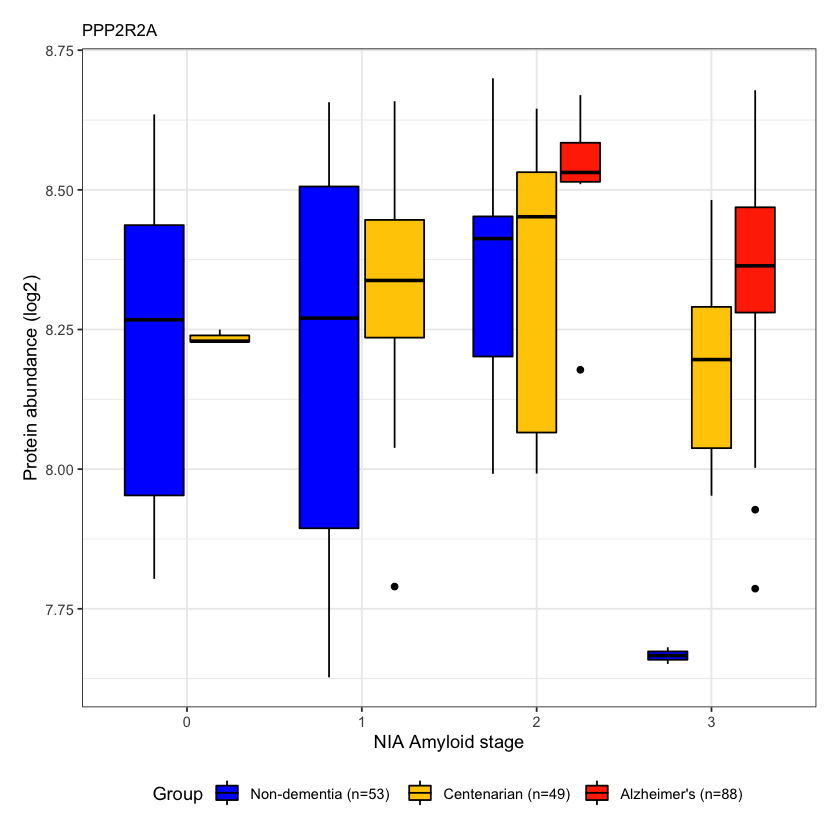

In [57]:
temp_prot <- data.frame(Abeta = as.factor(round(metadata$amyloid)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[rownames(protein_intensity_combat) == "PPP2R2A",]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "CHC", "AD"))

xlabels <- sort(unique(temp_prot$Abeta))
APP_plot <- ggplot(#subset(temp_prot, group != "AD"), 
                   temp_prot,
                   aes(x = Abeta, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("NIA Amyloid stage") +
    ylab("Protein abundance (log2)") +
    ggtitle("PPP2R2A") +
    scale_x_discrete(breaks=xlabels, labels = c("0", "1", "2", "3")) +

    scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                      values = c(color_ND, color_CHC, color_AD), 
                      labels = c("Non-dementia (n=53)", 
                                 "Centenarian (n=49)",
                                 "Alzheimer's (n=88)"
                                 )) +
    theme_bw() + theme(legend.position = "bottom",
                       plot.title = element_text(size = title_size),
                       plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm")) 
    
APP_plot

In [96]:
Abeta_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                                                       lm_sig_test, metadata[test_index, ]$amyloid)))
colnames(Abeta_related_proteins_lm) <- c("effect_size", "p_value")
Abeta_related_proteins_lm$adjusted_p_value <- p.adjust(Abeta_related_proteins_lm$p_value, 
                                                              method="BH")

In [97]:
Abeta_related_proteins_lm[order(Abeta_related_proteins_lm$adjusted_p_value), ]

,effect_size,p_value,adjusted_p_value
,<dbl>,<dbl>,<dbl>
APP,1.066599335,5.246381e-07,0.001808952
SLC12A2,0.018030593,7.455698e-01,0.998912364
CASKIN1,0.004688313,8.808354e-01,0.998912364
GNG2,-0.036823891,5.866634e-01,0.998912364
CARNS1,0.068237120,6.253759e-01,0.998912364
FH,-0.006081820,9.153252e-01,0.998912364
EFHD2,-0.031138733,7.730620e-01,0.998912364
PCLO,0.046862667,6.678906e-01,0.998912364
HSPA1A;HSPA1B,-0.054499817,2.640916e-01,0.998912364


In [76]:
test_index <- which((metadata$GROUP == "AD"))
length(test_index)

[1] 88

In [77]:
Braak_related_proteins_ANOVA <- as.data.frame(apply(protein_intensity_combat[, test_index], 1, 
                                                    cal_ANOVA_test, metadata[test_index, ]$fBraak))
colnames(Braak_related_proteins_ANOVA) <- c("p_value")
Braak_related_proteins_ANOVA$adjusted_p_value <- p.adjust(Braak_related_proteins_ANOVA$p_value,
                                                              method="BH")

In [78]:
Braak_related_proteins_ANOVA[which(Braak_related_proteins_ANOVA$adjusted_p_value < 0.05), ]

,p_value,adjusted_p_value
,<dbl>,<dbl>
CASKIN1,2.125623e-04,2.325446e-03
CARNS1,1.142881e-03,7.835467e-03
HSPA1A;HSPA1B,5.548881e-03,2.557826e-02
INPP5A,1.022776e-05,2.785262e-04
FMNL2,9.804045e-04,7.020949e-03
SYT12,8.613935e-07,5.711702e-05
GRHPR,1.823508e-05,3.961945e-04
DNAJC6,5.990162e-07,4.694108e-05
VDAC3,5.596175e-10,6.893447e-07


In [79]:
Braak_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, test_index], 1, 
                                                       lm_sig_test, metadata[test_index, ]$fBraak)))
colnames(Braak_related_proteins_lm) <- c("effect_size", "p_value")
Braak_related_proteins_lm$adjusted_p_value <- p.adjust(Braak_related_proteins_lm$p_value, 
                                                              method="BH")

In [80]:
Braak_related_proteins_lm[which(Braak_related_proteins_lm$adjusted_p_value < 0.05), ]

,effect_size,p_value,adjusted_p_value
,<dbl>,<dbl>,<dbl>
CASKIN1,-0.13180844,1.546500e-05,2.639768e-04
CARNS1,0.40959092,5.617527e-04,3.589751e-03
HSPA1A;HSPA1B,0.13246143,1.559575e-03,7.990217e-03
INPP5A,-0.12590237,3.139883e-05,4.210117e-04
PKP4,-0.11465542,6.198168e-03,2.248779e-02
CAMKV,-0.05776624,1.266722e-02,3.924221e-02
FMNL2,0.16633051,3.806776e-04,2.630414e-03
SYT12,-0.25872981,3.172782e-09,1.296012e-06
GRHPR,0.33549492,2.364007e-06,7.724581e-05


In [81]:
length(union(which(Braak_related_proteins_ANOVA$adjusted_p_value < 0.05), 
      which(Braak_related_proteins_lm$adjusted_p_value < 0.05)))

[1] 1237

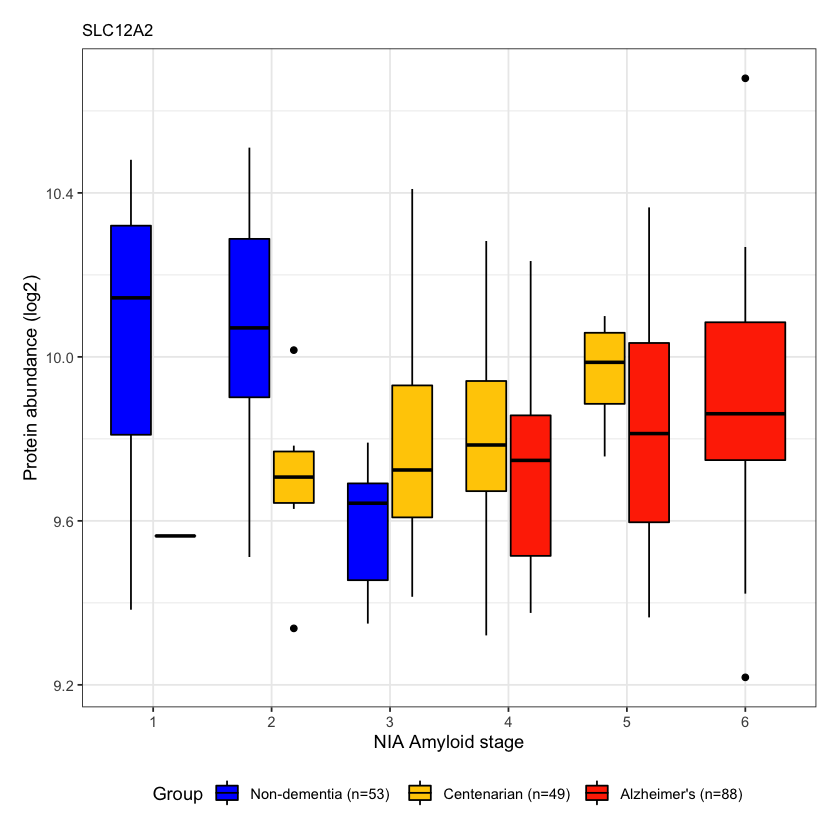

In [73]:
temp_prot <- data.frame(Abeta = as.factor(round(metadata$fBraak)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[rownames(protein_intensity_combat) == "SLC12A2",]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "CHC", "AD"))

xlabels <- sort(unique(temp_prot$Abeta))
APP_plot <- ggplot(#subset(temp_prot, group != "AD"), 
                   temp_prot,
                   aes(x = Abeta, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("NIA Amyloid stage") +
    ylab("Protein abundance (log2)") +
    ggtitle("SLC12A2") +
    #scale_x_discrete(breaks=xlabels, labels = c("0", "1", "2", "3")) +

    scale_fill_manual(name="Group", breaks = c("ND", "CHC", "AD"), 
                      values = c(color_ND, color_CHC, color_AD), 
                      labels = c("Non-dementia (n=53)", 
                                 "Centenarian (n=49)",
                                 "Alzheimer's (n=88)"
                                 )) +
    theme_bw() + theme(legend.position = "bottom",
                       plot.title = element_text(size = title_size),
                       plot.margin = ggplot2::margin(0.5, 0.5, 0.5, 0.5, "cm")) 
    
APP_plot